In [6]:
# Upload a zip file containing your frames (JPG/PNG)
uploaded = files.upload()  # choose e.g. JFK_4_frames.zip

zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

# Unzip into /content/frames
os.makedirs("frames", exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("frames")

image_paths = sorted(glob("frames/**/*.*", recursive=True))
print(f"Found {len(image_paths)} images")
image_paths[:5]


Saving JFK_1_frames.zip to JFK_1_frames.zip
Uploaded: JFK_1_frames.zip
Found 55 images


['frames/JFK_1_frames/frame_000001.png',
 'frames/JFK_1_frames/frame_000002.png',
 'frames/JFK_1_frames/frame_000003.png',
 'frames/JFK_1_frames/frame_000004.png',
 'frames/JFK_1_frames/frame_000005.png']

In [1]:
!pip install ultralytics albumentations opencv-python-headless matplotlib tqdm --quiet

from ultralytics import YOLO
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
import zipfile
from glob import glob
import json
import shutil
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# === Create YOLO config file ===

yaml_text = f"""
path: {os.path.abspath("crowdhuman_yolo")}

train: images/train
val: images/val

names:
  0: person
"""

with open("crowdhuman.yaml", "w") as f:
    f.write(yaml_text)

print(open("crowdhuman.yaml").read())

# === Train YOLOv8n ===
model = YOLO("yolov8n.pt")

results = model.train(
    data="crowdhuman.yaml",
    imgsz=640,
    epochs=30,    # increase if GPU ok
    batch=16,
    project="crowdhuman_training",
    name="yolov8n_finetuned",
    exist_ok=True
)

# === SAVE TRAINED MODEL TO GOOGLE DRIVE ===

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil

save_dir = "/content/drive/MyDrive/crowdhuman_models"
os.makedirs(save_dir, exist_ok=True)

src_best = "crowdhuman_training/yolov8n_finetuned/weights/best.pt"
src_last = "crowdhuman_training/yolov8n_finetuned/weights/last.pt"

if os.path.exists(src_best):
    shutil.copy(src_best, f"{save_dir}/best.pt")
    print("✔ Saved best.pt to Drive")

if os.path.exists(src_last):
    shutil.copy(src_last, f"{save_dir}/last.pt")
    print("✔ Saved last.pt to Drive")

print(f"📁 Models saved at: {save_dir}")


# Load fine-tuned weights
model = YOLO("crowdhuman_training/yolov8n_finetuned/weights/best.pt")
print("Loaded fine-tuned YOLO model.")


Streaming output truncated to the last 5000 lines.
train: /content/crowdhuman_yolo/images/train/273275,819c50007bfdb62f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0763      1.0575]
train: /content/crowdhuman_yolo/images/train/273275,8312900043781e3e.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.108]
train: /content/crowdhuman_yolo/images/train/273275,831d000414562a3.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1016]
train: /content/crowdhuman_yolo/images/train/273275,83431000f208de32.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0562]
train: /content/crowdhuman_yolo/images/train/273275,83a1d000add36ba7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0234]
train: /content/crowdhuman_yolo/images/train/273275,83e8200089523cc8.jpg: ignoring corrupt image/label: non-normalized or out of

In [14]:
#cell 3
def yolo_heatmap_on_image(img_bgr, model, conf_thresh=0.15, sigma=25):
    """
    img_bgr: OpenCV BGR image
    model: YOLO model
    conf_thresh: minimum confidence for keeping a detection
    sigma: Gaussian blur strength for heatmap
    """
    h, w = img_bgr.shape[:2]

    # Run YOLO
    results = model.predict(
        source=img_bgr,
        conf=conf_thresh,
        verbose=False
    )[0]

    # Count persons + create point map
    point_map = np.zeros((h, w), dtype=np.float32)
    person_count = 0

    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        if cls != 0 or conf < conf_thresh:  # class 0 = person
            continue

        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        if 0 <= cx < w and 0 <= cy < h:
            point_map[cy, cx] += 1.0
            person_count += 1

    # Turn point map into smooth heatmap
    heatmap = cv2.GaussianBlur(point_map, (0, 0), sigmaX=sigma, sigmaY=sigma)

    # Normalize heatmap to [0, 255]
    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_norm = heatmap_norm.astype(np.uint8)

    # Colorize
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    # Overlay onto original frame
    overlay = cv2.addWeighted(img_bgr, 0.6, heatmap_color, 0.4, 0)

    # Get YOLO's built-in annotated image (boxes, labels)
    annotated = results.plot()  # returns BGR image

    return annotated, overlay, person_count


In [15]:
#cell 4
os.makedirs("outputs/annotated", exist_ok=True)
os.makedirs("outputs/heatmap_overlay", exist_ok=True)

counts = []

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    img_bgr = cv2.imread(img_path)

    if img_bgr is None:
        print("Could not read:", img_path)
        continue

    annotated, overlay, person_count = yolo_heatmap_on_image(
        img_bgr,
        model,
        conf_thresh=0.15,  # adjust if needed
        sigma=25          # bigger sigma => smoother heatmap
    )

    # Save images
    cv2.imwrite(f"outputs/annotated/{img_name}", annotated)
    cv2.imwrite(f"outputs/heatmap_overlay/{img_name}", overlay)

    counts.append((img_name, person_count))

    print(f"{img_name}: {person_count} people")

# Save counts to a simple CSV-like text
with open("outputs/crowd_counts.txt", "w") as f:
    f.write("frame,person_count\n")
    for name, c in counts:
        f.write(f"{name},{c}\n")

print("Done.")


frame_000001.png: 12 people
frame_000002.png: 19 people
frame_000003.png: 16 people
frame_000004.png: 16 people
frame_000005.png: 17 people
frame_000006.png: 16 people
frame_000007.png: 13 people
frame_000008.png: 19 people
frame_000009.png: 20 people
frame_000010.png: 21 people
frame_000011.png: 19 people
frame_000012.png: 17 people
frame_000013.png: 19 people
frame_000014.png: 8 people
frame_000015.png: 10 people
frame_000016.png: 10 people
frame_000017.png: 5 people
frame_000018.png: 2 people
frame_000019.png: 1 people
frame_000020.png: 1 people
frame_000021.png: 2 people
frame_000022.png: 2 people
frame_000023.png: 3 people
frame_000024.png: 3 people
frame_000025.png: 6 people
frame_000026.png: 6 people
frame_000027.png: 16 people
frame_000028.png: 16 people
frame_000029.png: 16 people
frame_000030.png: 9 people
frame_000031.png: 15 people
frame_000032.png: 7 people
frame_000033.png: 5 people
frame_000034.png: 7 people
frame_000035.png: 14 people
frame_000036.png: 8 people
frame_00

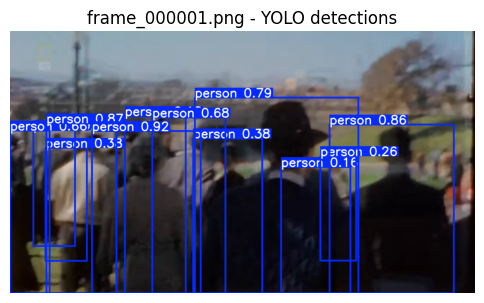

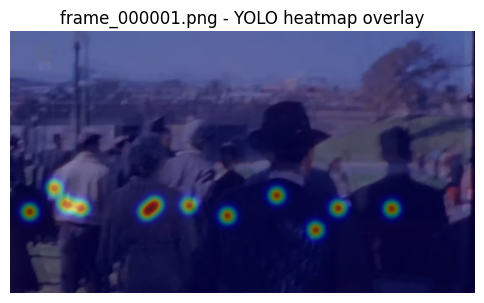

In [16]:
def show_image(path, title=""):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()

example = counts[0][0]  # first frame name

show_image(f"outputs/annotated/{example}", title=f"{example} - YOLO detections")
show_image(f"outputs/heatmap_overlay/{example}", title=f"{example} - YOLO heatmap overlay")


In [ ]:
!zip -r outputs_yolo_heatmaps.zip outputs
files.download("outputs_yolo_heatmaps.zip")


  adding: outputs/ (stored 0%)
  adding: outputs/crowd_counts.txt (deflated 81%)
  adding: outputs/heatmap_overlay/ (stored 0%)
  adding: outputs/heatmap_overlay/frame_000045.png (deflated 6%)
  adding: outputs/heatmap_overlay/frame_000009.png (deflated 7%)
  adding: outputs/heatmap_overlay/frame_000027.png (deflated 8%)
  adding: outputs/heatmap_overlay/frame_000055.png (deflated 6%)
  adding: outputs/heatmap_overlay/frame_000053.png (deflated 5%)
  adding: outputs/heatmap_overlay/frame_000037.png (deflated 7%)
  adding: outputs/heatmap_overlay/frame_000020.png (deflated 10%)
  adding: outputs/heatmap_overlay/frame_000006.png (deflated 7%)
  adding: outputs/heatmap_overlay/frame_000030.png (deflated 7%)
  adding: outputs/heatmap_overlay/frame_000041.png (deflated 6%)
  adding: outputs/heatmap_overlay/frame_000018.png (deflated 12%)
  adding: outputs/heatmap_overlay/frame_000051.png (deflated 7%)
  adding: outputs/heatmap_overlay/frame_000026.png (deflated 9%)
  adding: outputs/heatmap

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>